In [2]:
import os
import random
import json
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

In [14]:
from model import process_json
from model import TennisDataset, HitBounceBiLSTM, FocalLoss, BalancedBatchSampler, BalancedTennisDataset

In [3]:
def split_json_files(data_dir, train_ratio=0.8, seed=42):
    files = [os.path.join(data_dir, f)
             for f in os.listdir(data_dir)
             if f.endswith(".json")]

    random.seed(seed)
    random.shuffle(files)

    n_train = int(len(files) * train_ratio)

    train_files = files[:n_train]
    val_files = files[n_train:]

    return train_files, val_files

In [ ]:
DATA_DIR = "Data hit & bounce/per_point_v2"
train_files, val_files = split_json_files(DATA_DIR)

In [25]:
# FOR BALANCED BATCH SAMPLER
from torch.utils.data import DataLoader

batch_size = 12  # divisible par 3

train_dataset = BalancedTennisDataset(train_files, window=5)
val_dataset = BalancedTennisDataset(val_files, window=5)

balanced_sampler = BalancedBatchSampler(
    labels=train_dataset.labels,
    batch_size=batch_size
)

train_loader = DataLoader(
    train_dataset,
    batch_sampler=balanced_sampler,
    num_workers=0
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)


In [5]:
from torch.utils.data import DataLoader

window = 5

train_dataset = TennisDataset(train_files, window)
val_dataset   = TennisDataset(val_files, window)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False
)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HitBounceBiLSTM(input_dim=9).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
class_weights = torch.tensor([0.010, 1.11, 1.23]) # 1/ percentage of each class * 100
criterion = nn.CrossEntropyLoss(weight=class_weights)
#gamma = 2.0

#criterion = FocalLoss(alpha=torch.tensor([1.0, 5.0, 5.0]), gamma=gamma)


In [8]:
def train_epoch(model, loader):
    model.train()
    total_loss = 0

    for X, y in loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [9]:
def eval_epoch(model, loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            preds = torch.argmax(logits, dim=1)

            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total


In [10]:
LABEL_MAP = {"air": 0, "hit": 1, "bounce": 2}
LABEL_NAMES = ["air", "hit", "bounce"]

def eval_epoch_metrics(model, loader, device):
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device).float()
            y = y.to(device).long()

            logits = model(X)
            preds = torch.argmax(logits, dim=1)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    report = classification_report(
        all_targets,
        all_preds,
        target_names=LABEL_NAMES,
        digits=4,
        output_dict=True
    )

    return report


In [11]:
from collections import defaultdict
import json


In [12]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def eval_epoch_full(model, loader, device):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device).float()
            y = y.to(device).long()

            logits = model(X)
            preds = torch.argmax(logits, dim=1)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(y.cpu().numpy())

    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_preds)

    acc = accuracy_score(y_true, y_pred)

    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=[0,1,2], zero_division=0
    )

    return {
        "accuracy": acc,
        "precision": p.tolist(),
        "recall": r.tolist(),
        "f1": f1.tolist()
    }


In [26]:
for X, y in train_loader:
    print(X.shape, y.bincount())
    break


torch.Size([12, 5, 9]) tensor([4, 4, 4])


In [ ]:
def resume_train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    num_epochs=20,
    save_dir="experiments/balnced_batch_run",
    save_every=5,
    resume_from=None
):
    os.makedirs(f"{save_dir}/checkpoints", exist_ok=True)
    history = defaultdict(list)
    start_epoch = 0


    if resume_from is not None:
        ckpt = torch.load(resume_from, map_location=device)

        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        start_epoch = ckpt["epoch"]

        print(f"Resume from {resume_from} (epoch {start_epoch})")

        # recharge historique si existant
        metrics_path = f"{save_dir}/metrics.json"
        if os.path.exists(metrics_path):
            with open(metrics_path, "r") as f:
                old_history = json.load(f)
            for k, v in old_history.items():
                history[k] = v


    for epoch in range(start_epoch, num_epochs):
        train_loss = train_epoch(
            model, train_loader
        )
        metrics = eval_epoch_full(model, val_loader, device)

        history["train_loss"].append(train_loss)
        history["val_accuracy"].append(metrics["accuracy"])
        history["precision"].append(metrics["precision"])
        history["recall"].append(metrics["recall"])
        history["f1"].append(metrics["f1"])

        print(
            f"Epoch {epoch+1:02d} | "
            f"Loss={train_loss:.4f} | "
            f"Acc={metrics['accuracy']:.3f} | "
            f"MacroF1={np.mean(metrics['f1']):.3f}"
        )

        # checkpoint périodique
        if (epoch + 1) % save_every == 0:
            ckpt_path = f"{save_dir}/checkpoints/epoch_{epoch+1:02d}.pt"
            torch.save({
                "epoch": epoch + 1,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "metrics": metrics
            }, ckpt_path)

            # sauvegarde continue de l’historique
            with open(f"{save_dir}/metrics.json", "w") as f:
                json.dump(history, f, indent=2)

    return history

In [46]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12,4))

    # Accuracy
    plt.subplot(1,3,1)
    plt.plot(epochs, history["val_accuracy"])
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")

    # Precision / Recall par classe
    plt.subplot(1,3,2)
    for i, label in enumerate(["air", "hit", "bounce"]):
        p = [ep[i] for ep in history["precision"]]
        r = [ep[i] for ep in history["recall"]]
        plt.plot(epochs, p, label=f"P-{label}")
        plt.plot(epochs, r, linestyle="--", label=f"R-{label}")
    plt.legend()
    plt.title("Precision / Recall")

    # F1
    plt.subplot(1,3,3)
    for i, label in enumerate(["air", "hit", "bounce"]):
        f1 = [ep[i] for ep in history["f1"]]
        plt.plot(epochs, f1, label=f"F1-{label}")
    plt.legend()
    plt.title("F1-score")

    plt.tight_layout()
    plt.show()

In [42]:
history_balanced_batch = resume_train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    num_epochs=200,
    save_dir="experiments/balnced_batch_run",
    resume_from="experiments/balnced_batch_run/checkpoints/epoch_200.pt"
)
history_focal_loss = resume_train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    num_epochs=50,
    save_dir="experiments/focal_loss_run",
    resume_from="experiments/focal_loss_run/checkpoints/epoch_50.pt"
)
history_cross_entropy = resume_train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    num_epochs=100,
    save_dir="experiments/run_01",
    resume_from="experiments/run_01/checkpoints/epoch_100.pt"
)

Resume from experiments/balnced_batch_run/checkpoints/epoch_200.pt (epoch 200)
Resume from experiments/focal_loss_run/checkpoints/epoch_50.pt (epoch 50)
Resume from experiments/run_01/checkpoints/epoch_100.pt (epoch 100)


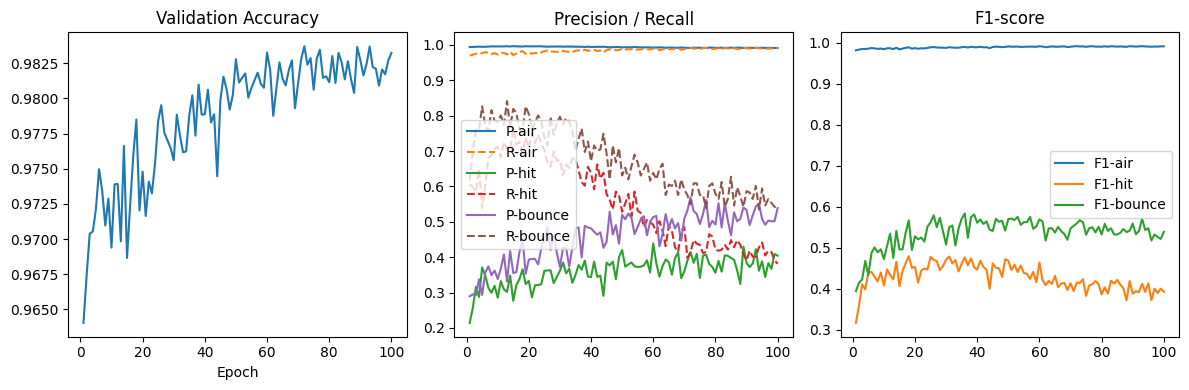

In [49]:
# Plot metrics for cross-entropy run (cross entropy loss with weighted classes in the loss function)
plot_metrics(history_cross_entropy)

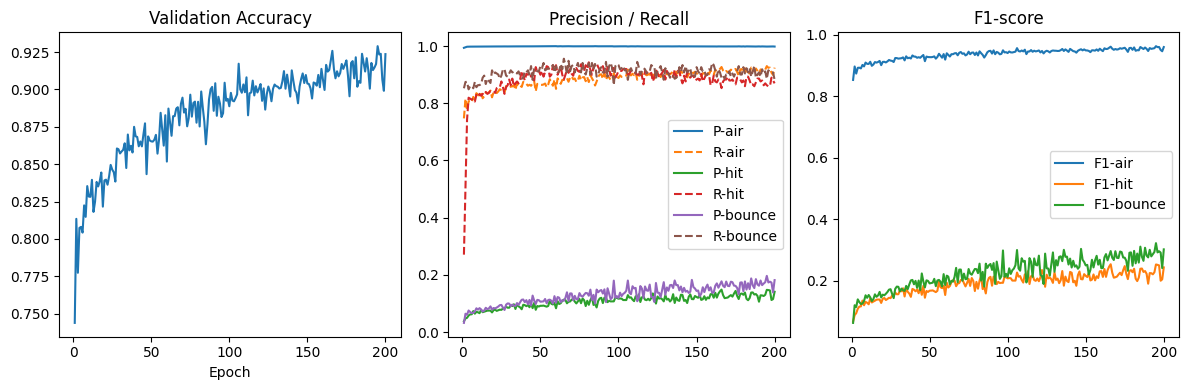

In [48]:
# Plot metrics for balanced batch run (1/3 hit, 1/3 bounce, 1/3 air with cross-entropy loss)
plot_metrics(history_balanced_batch)

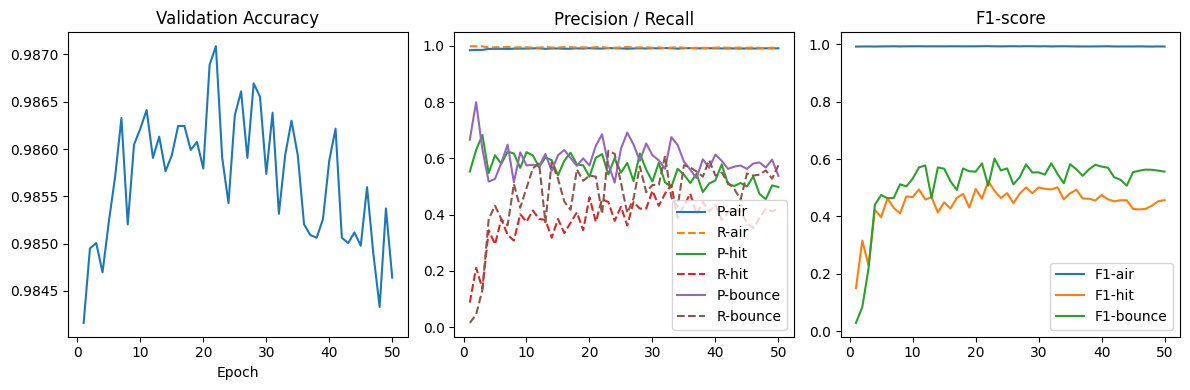

In [50]:
# Plot metrics for focal loss run 
plot_metrics(history_focal_loss)

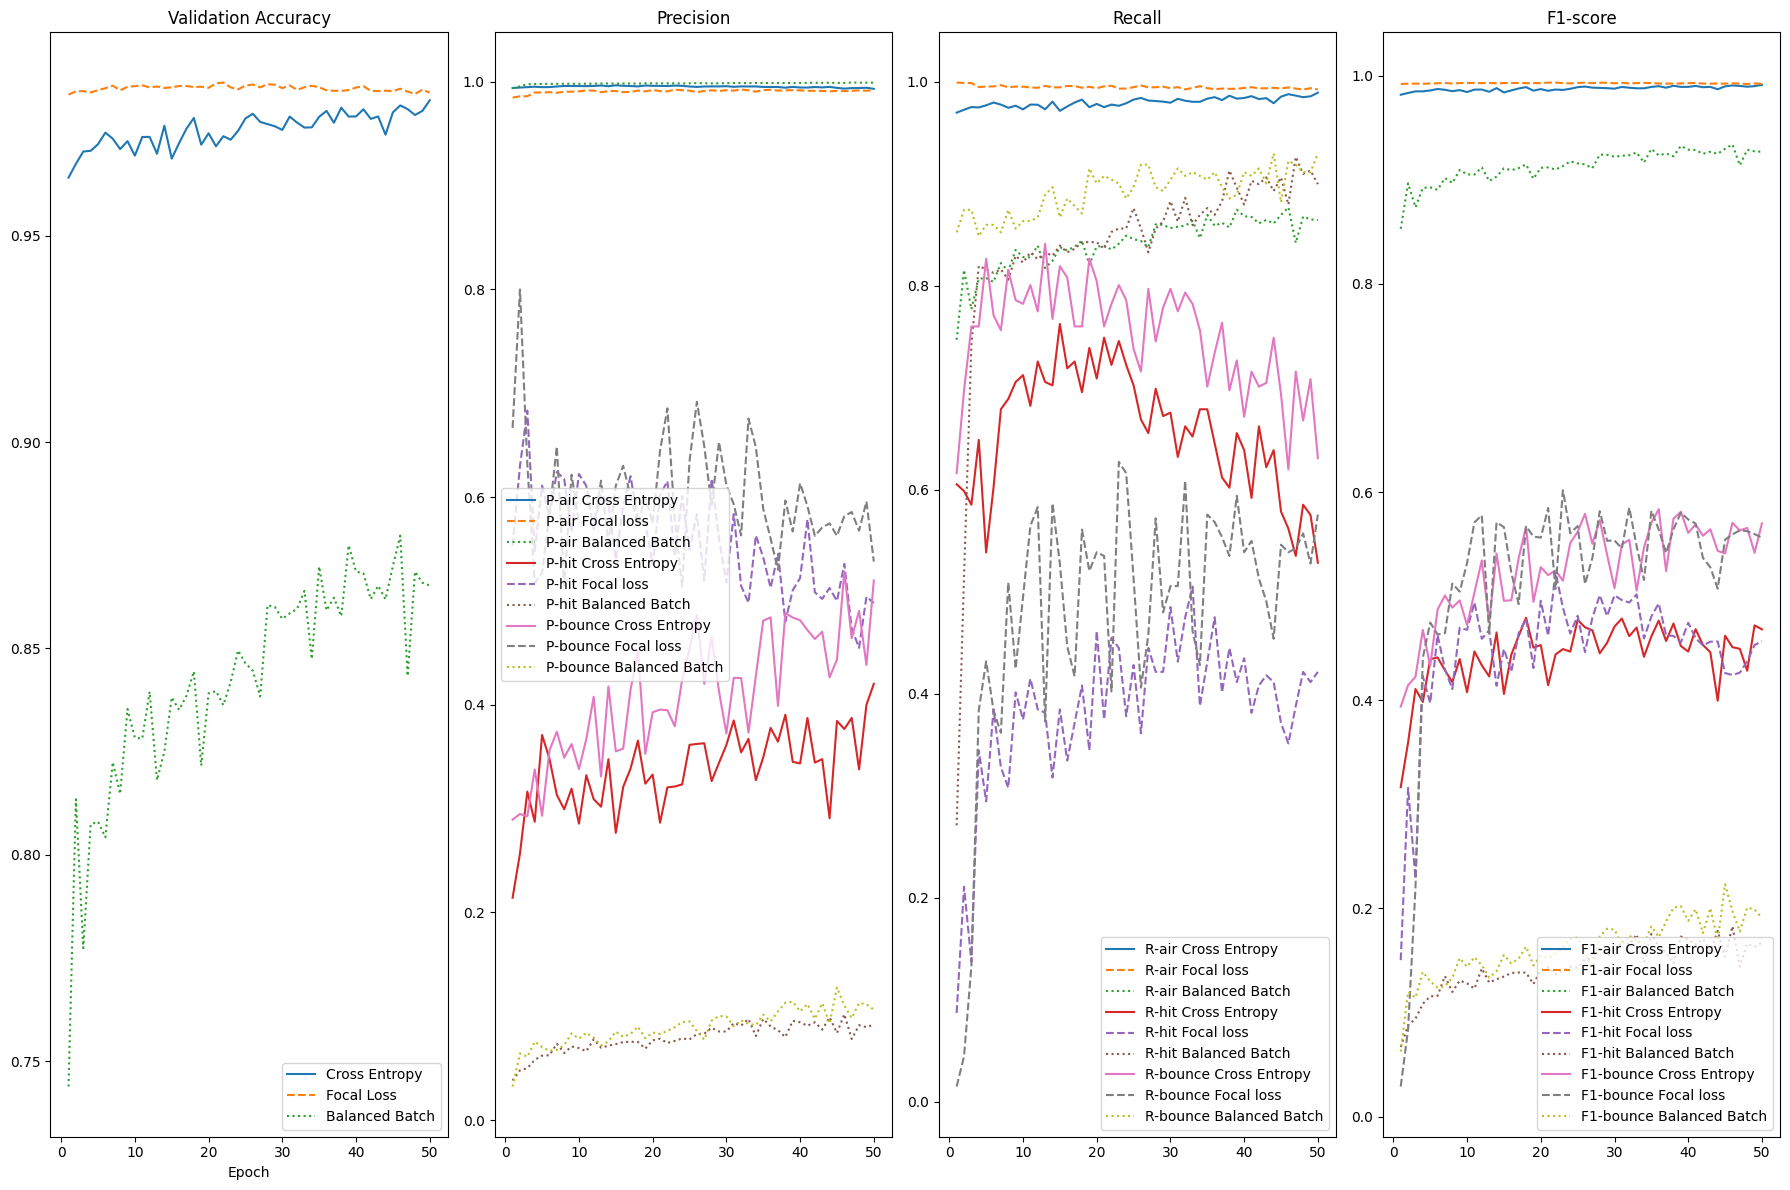

In [59]:
#plots to compare all three training methods

epochs = range(1, len(history_focal_loss["train_loss"]) + 1)
plt.figure(figsize=(18,12))

# Accuracy
plt.subplot(1,4,1)
plt.plot(epochs, history_cross_entropy["val_accuracy"][:50], label="Cross Entropy")
plt.plot(epochs, history_focal_loss["val_accuracy"], linestyle="--", label="Focal Loss")
plt.plot(epochs, history_balanced_batch["val_accuracy"][:50], linestyle=":", label="Balanced Batch")
plt.legend()
plt.title("Validation Accuracy")
plt.xlabel("Epoch")

# Precision
plt.subplot(1,4,2)
for i, label in enumerate(["air", "hit", "bounce"]):
    p_ce = [ep[i] for ep in history_cross_entropy["precision"][:50]]
    p_fl = [ep[i] for ep in history_focal_loss["precision"]]
    p_bb = [ep[i] for ep in history_balanced_batch["precision"][:50]]
    plt.plot(epochs, p_ce, label=f"P-{label} Cross Entropy")
    plt.plot(epochs, p_fl, linestyle="--", label=f"P-{label} Focal loss")
    plt.plot(epochs, p_bb, linestyle=":", label=f"P-{label} Balanced Batch")
plt.legend()
plt.title("Precision")

#recall
plt.subplot(1,4,3)
for i, label in enumerate(["air", "hit", "bounce"]):
    r_ce = [ep[i] for ep in history_cross_entropy["recall"][:50]]
    r_fl = [ep[i] for ep in history_focal_loss["recall"]]
    r_bb = [ep[i] for ep in history_balanced_batch["recall"][:50]]
    plt.plot(epochs, r_ce, label=f"R-{label} Cross Entropy")
    plt.plot(epochs, r_fl, linestyle="--", label=f"R-{label} Focal loss")
    plt.plot(epochs, r_bb, linestyle=":", label=f"R-{label} Balanced Batch")
plt.legend()
plt.title("Recall")

# F1
plt.subplot(1,4,4)
for i, label in enumerate(["air", "hit", "bounce"]):
    f1_ce = [ep[i] for ep in history_cross_entropy["f1"][:50]]
    f1_fl = [ep[i] for ep in history_focal_loss["f1"]]
    f1_bb = [ep[i] for ep in history_balanced_batch["f1"][:50]]
    plt.plot(epochs, f1_ce, label=f"F1-{label} Cross Entropy")
    plt.plot(epochs, f1_fl, linestyle="--", label=f"F1-{label} Focal loss")
    plt.plot(epochs, f1_bb, linestyle=":", label=f"F1-{label} Balanced Batch")
plt.legend()
plt.title("F1-score")

plt.tight_layout()
plt.show()